In [1]:
#| default_exp training

In [2]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor,nn
import torch.nn.functional as F
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

## Initial setup

### Data

In [3]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50   # hidden
v,w = x_valid.shape
n,m,int(c), v, w

(50000, 784, 10, 10000, 784)

In [4]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [5]:
model = Model(m, nh, c)
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

In [6]:
pred[:5]

tensor([[-0.09, -0.21, -0.08,  0.10, -0.04,  0.08, -0.04, -0.03,  0.01,  0.06],
        [-0.07, -0.14, -0.14, -0.03, -0.00,  0.13, -0.04,  0.03,  0.04,  0.14],
        [-0.19, -0.04,  0.02,  0.21, -0.06, -0.00, -0.08, -0.01, -0.00,  0.02],
        [-0.05, -0.21, -0.07,  0.08,  0.04,  0.08, -0.10, -0.01,  0.09,  0.01],
        [-0.15, -0.19, -0.04,  0.06, -0.05,  0.15, -0.11,  0.01,  0.08,  0.05]], grad_fn=<SliceBackward0>)

### Cross entropy loss

First, we will need to compute the softmax of our activations. This is defined by:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum\limits_{0 \leq j \lt n} e^{x_{j}}}$$ 

In practice, we will need the log of the softmax when we calculate the loss.

Below $e^{x_{i}} =$ `x.exp()`, and $ \sum\limits_{0 \leq j \lt n} e^{x_{j}}$ = `(x.exp().sum(-1,keepdim=True))`

Note that the formula $\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$
gives a simplification when we compute the log softmax:<br>
$log(a) =$ `x` ,  $log(b) =$ `x.exp().sum(-1,keepdim=True).log()`

In cross-entropy, we don't want softmax, we want log of softmax:
We want to keep that dimension `keepdim=True` so that when we do the divided by, 
we want a trailing unit axis (for the same reason as when we did our MSE loss function).
A `sum()` with `keepdim=True` leaves a unit axis in that last position,
so we don't have to put it back to avoid the broadcasting product issue.

In [7]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

log_softmax(pred)

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<SubBackward0>)

Problem: we have `x.exp.sum()`, `x` could be big numbers, then `exp(x)` is very big numbers.   
There is less precision in the computer's floating point handling the further we get away from zero.
We don't want big numbers, particularly because we're going to be taking  derivatives, 
and in an area that is not floating point precise, the derivatives are going to be a "disaster".
They might be 0 when we have 2 numbers that the computer can't recognize as different.
Lets define $a=max(x_i)$, the maximum of the $x_i$s.
We want to avoid doing $log(\sum(exp(x_i))$.
If we subtract $a$ from every $x_i$, then the numbers are smaller, but that is given us a different result. 
Let's expand this sum: it is $S = e^{x_1-a} + e^{x_2 -a} + \cdots +e^{x_j -a} $
We subtracted $a$ from our exponents, which means we're now wrong. 
By exponent rules, $x^{a+b} = x^a * x^b$, and   $x^{a-b} = x^a \div x^b$
<br>
We use this rule, so $S= \frac{e^{x_1}}{e^a} + \frac{e^{x_2}}{e^a}\cdots \frac{e^{x_j}}{e^a}$.
Now $e^a$ is a common  denominator, so we can put all that together, 
multiply by $e^a$, these would cancel out and we get the thing we originally wanted.
But this is no longer going to be a giant number. 
We're did extra calculations to make it easier for our floating point unit. 

This is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:
$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$
where $a$ is the maximum of the $x_{j}$.

See above the output of `preds[:5]` to confirm the maxs

In [8]:
a = pred.max(-1)[0]
a, a.shape

(tensor([0.10, 0.14, 0.21,  ..., 0.14, 0.11, 0.14], grad_fn=<MaxBackward0>),
 torch.Size([50000]))

Below using the LogSumExp trick, where: 
$ \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right) $ = `x-a[:,None]).exp().sum(-1).log()`

In [9]:
def logsumexp(x):
    a = x.max(-1)[0]  # a is a in the above formula, the max of the xj
    return a + (x - a[:,None]).exp().sum(-1).log()

This way, we will avoid an overflow when taking the exponential of a big activation. <br>
PyTorch implements this as `torch.logsumexp()`. 

In [10]:
test_close(logsumexp(pred), torch.logsumexp(pred, dim=-1))

In [11]:
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

In [12]:
sm_pred = log_softmax(pred)
sm_pred

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<SubBackward0>)

The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:
$$ -\sum x\, \log p(x) $$
<br>
But since our $x$s are just integer indices, this can be rewritten as 
$-\log(p_{i})$ where $i$ is the index of the desired target.

This can be done using numpy-style [integer array indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html#integer-array-indexing). (PyTorch supports all the advanced indexing methods discussed in that link).

In [13]:
y_train[:3]  # first 3 targets are:

tensor([5, 0, 4])

Above are the first three label values in `y_train`: 5, 0, and 4.
We want to find in our softmax predictions:
the 5th prediction in the zeroth row, the 0 prediction in the first row, and the 4th prediction in the index two row.

In [14]:
sm_pred[0,5],sm_pred[1,0],sm_pred[2,4] # the predictions for the targets are:

(tensor(-2.20, grad_fn=<SelectBackward0>),
 tensor(-2.37, grad_fn=<SelectBackward0>),
 tensor(-2.36, grad_fn=<SelectBackward0>))

Above is going to be what we add up for the first rows of our loss function. 
We use an "index trick" to do it all at once.
We index using two lists: the first index is the list `[0, 1, 2]`, and the second index is `y_train[:3]`.
So the indeces are going to be `[0,5]`, `[1,0]`, and `[2,4]`,  which is the same thing as above. 

In [15]:
sm_pred[[0,1,2], y_train[:3]]  # advanced indexing....

tensor([-2.20, -2.37, -2.36], grad_fn=<IndexBackward0>)

In [16]:
sm_pred.shape, sm_pred.shape[0]

(torch.Size([50000, 10]), 50000)

Therefore, the "2 list indexing" is giving us what we need for the cross entropy loss. 
Lets take as first index the `range` of our target's first (`[0]` index) dimension,
e.g., `range(5000)`, and as 2nd index the `target` list, e.g., the labels `y_train`.
Take the negative of that `.mean()`,  that gives us our cross entropy loss.

In [17]:
def nll(input, target): return -input[range(target.shape[0]), target].mean()

PyTorch calls this negative log likelihood `nll` loss.
We compute the `nll`  then pass the result to the `log_softmax`, to get the loss. 

In [18]:
loss = nll(sm_pred, y_train)
loss.item()

2.300276279449463

Then use PyTorch's implementation.

In [19]:
F.nll_loss(F.log_softmax(pred, -1), y_train)

tensor(2.30, grad_fn=<NllLossBackward0>)

In [20]:
test_close(F.nll_loss(F.log_softmax(pred, -1), y_train), loss, 1e-4)

In PyTorch, `F.log_softmax` and `F.nll_loss` are combined in one function, `F.cross_entropy`,
lets check that it gives us the same thing.

In [21]:
test_close(F.cross_entropy(pred, y_train), loss, 1e-5)

HW: there are lots of confusing things going on. 
Lets look at each step, think what and why is doing it.
Experiment with different values to see what's going on.
HW: Reimplement `log_softmax(), nll_loss() and cross_entropy()` and compare them to PyTorch's values.

## Basic training loop

Basically the training loop repeats over the following steps:
- get the output of the model on a batch of inputs
- compare the output to the labels we have and compute a loss
- calculate the gradients of the loss with respect to every parameter of the model
- update said parameters with those gradients to make them a little bit better

Lets setup to create a training loop.
The loss function is `F.cross_entropy`, the batch size `bs=64`. 
`xb` is the first minibatch,from 0 to 64 from the training set. 
The predictions `preds` are returned by calling the `model(xb)`, and the result is `[64,10]`, 
for each image in the minibatch we have 10 probabilities, one for each digit.

In [22]:
loss_func = F.cross_entropy

bs=64                 # batch size
xb = x_train[0:bs]     # a mini-batch from x of size bs
preds = model(xb)      # predictions for this mini-batch
preds.shape

torch.Size([64, 10])

In [23]:
preds[0]   # predictions for first image

tensor([-0.09, -0.21, -0.08,  0.10, -0.04,  0.08, -0.04, -0.03,  0.01,  0.06], grad_fn=<SelectBackward0>)

The `yb`s are the first 64 target values the actual digits. 

In [24]:
yb = y_train[0:bs] # the corresponding (true) targets
yb.shape, yb

(torch.Size([64]),
 tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
         3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0]))

We start with a bad loss because on the first batch step the weights are entirely random.  

In [25]:
loss_func(preds, yb)   #, loss_func(preds, yb).item() 

tensor(2.30, grad_fn=<NllLossBackward0>)

What did we predict? 
For each one of the 64 rows, we have to go get the highest prediction number,
i.e., we've to find the index of the highest number, and for this we use `argmax()`. 

In [26]:
preds.argmax(dim=1) # take the argmax on the column 1 same as torch.argmax(preds, dim=1)

tensor([3, 9, 3, 8, 5, 9, 3, 9, 3, 9, 5, 3, 9, 9, 3, 9, 9, 5, 8, 7, 9, 5, 3, 8, 9, 5, 9, 5, 5, 9, 3, 5, 9, 7, 5, 7, 9, 9, 3, 9, 3, 5, 3, 8,
        3, 5, 9, 5, 9, 5, 3, 9, 3, 8, 9, 5, 9, 5, 9, 5, 8, 8, 9, 8])

We want to calculate accuracy as a metric for understanding. 
So we take the `out.argmax` and compare it to the actuals `yb`, returns a bunch of booleans. 
We turn those into floats to be 1.0s and 0.0s and the `mean` of those floats is the accuracy. 
The current accuracy, as expected, is around 10%, because we havent trained yet, it is random. 

In [27]:
def accuracy(out, yb): return (out.argmax(dim=1)==yb).float().mean()

accuracy(preds, yb)

tensor(0.09)

To train lets set a learning rate `lr` and do a few (3) `epochs`. 

In [28]:
lr = 0.5   # learning rate
epochs = 3 # how many epochs to train for

Lets define a `report` function to print the `loss` and `accuracy`.
below (`:.3f`) is a format specifier of Python

In [29]:
def report(loss, preds, yb): print(f'{loss:.3f}, {accuracy(preds, yb):.3f}')

In [30]:
xb,yb = x_train[:bs],y_train[:bs]
preds = model(xb)
print('Loss  Accuracy')
report(loss_func(preds, yb), preds, yb)

Loss  Accuracy
2.304, 0.094


For each `epoch` and we're going to go with `i` through the `n` (the 50,000 training rows),
skipping by 64, the batch size, each time.
We create a slice `s` that starts at `i`, e.g., 0, and goes up to  64,
unless we've gone past the end, in which case we'll just go up to `n`. 
We slice into our training set for the `xb` and `yb` batches.  
We calculate the predictions `pred`,  our `loss` function, and do the `loss.backward()`.
Then, with `torch.no_grad()`, we go through each layer `l` in `model.layers`.
If the layer has `weight`, we update them to current weights minus the gradients `l.weights.grad` times `lr`.
And then zero out the gradients of the weights and biases with `.grad_zero_()`.
The last `_` means do it in place. 

In [31]:
print('Loss  Accuracy')
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad   * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()
    report(loss, preds, yb)

Loss  Accuracy
0.191, 0.938
0.047, 1.000
0.032, 1.000


Our accuracy on  the training set, only three epochs,...
We now have a handwritten digit recognizer that trains quickly.
Next time we're going to refactor this training loop to make it simpler.
Then we're going to add a validation set to it and a multi-processing data loader.
Then we'll be in a good position to start training some more interesting models.

HW: TODO: recreate matrix  multiply, forward and backward passes, something that steps through layers.
Recreate the idea of `.forward` and `.backward`.  
Make sure to fully understand what's going on. 
First pick a smaller part of that, the most interesting part, 
or just go through and look really closely at these notebooks. 
Restart the notebook kernel and clear output, try to think what are the shapes and values of the variables.

## Using parameters and optim

### Parameters
PyTorch's torch.nn has the `nn.Module` class. 
We don't normally use it this way, just to see how it works. 
We create an instance `m1` of Module and can assign things to its attributes, e.g.
assign a linear layer to it. 
We print `m1` and it is a  module containing foo, a linear layer. 

In [32]:
m1 = nn.Module()
m1.foo = nn.Linear(3,4)
m1

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
)

Then we can ask show me all of the named children of that module.
If we call `m1.named_children()`, it just prints out the generator object, which is not very  helpful. 
A generator will only produce contents when we "do something" with it, e.g., list them out.

In [33]:
m1.named_children()

<generator object Module.named_children at 0x111644120>

So just popping a list around a generator is one way to run the generator and get its output. 
There's one child `foo` and it's a linear layer.  

In [34]:
list(m1.named_children())   #trick to look inside generator

[('foo', Linear(in_features=3, out_features=4, bias=True))]

And we can ask for all of the `parameters` of this module:
There's two: a 4x3 tensor for the weights, and a 4 long vector, that's the biases.  

In [35]:
list(m1.parameters())

[Parameter containing:
 tensor([[ 0.57,  0.43, -0.30],
         [ 0.13, -0.32, -0.24],
         [ 0.51,  0.04,  0.22],
         [ 0.13, -0.17, -0.24]], requires_grad=True),
 Parameter containing:
 tensor([-0.01, -0.51, -0.39,  0.56], requires_grad=True)]

We could use `__call__`,  but it is better to refactor using `forward` 
such that it would automatically do what is necessary to make all the automatic gradients.

In [36]:
class MLP(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        self.relu = nn.ReLU()
        
    def forward(self, x): return self.l2(self.relu(self.l1(x)))

This is an  example of creating a custom PyTorch module, that knows what are all the attributes
we added to it and what are all the parameters. 

In [37]:
model = MLP(m, nh, c)
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [38]:
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [39]:
for name,l in model.named_children(): print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


We can go through the `model.parameters` and print out their shapes:
`l1` weights, `l1` biases, `l2` weights and biases.

In [40]:
for p in model.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


Now we don't have to write the loop going through layers and making sure that they've all been put into a list.
We've just been able to add them as attributes and they're automatically going to appear as parameters. 
So we can just go through each parameter and update it based on the gradient and the learning rate:
`for p in model.parameters(): p -= p.grad * lr`
And `model.zero_grad()` will zero out all of the gradients.
That made our code simpler and more flexible.

In [41]:
def fit():
    for epoch in range(epochs):
        for i in range(0, n, bs):
            s = slice(i, min(n,i+bs))
            xb,yb = x_train[s],y_train[s]
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()
        report(loss, preds, yb)

If we called `report()` on this before `fit()` the accuracy is about 10%, and the loss is pretty high.

In [42]:
xc,yc = x_train[:bs],y_train[:bs]
preds = model(xc)
print('Loss  Accuracy')
report(loss, preds, yc)

Loss  Accuracy
0.032, 0.047


And so after I run this fit(), this model,  the accuracy goes up and the loss goes down.  

In [43]:
fit()

0.408, 0.938
0.098, 1.000
0.048, 1.000


Behind the scenes, PyTorch overrides the `__setattr__` function in `nn.Module` so that the submodules you define are properly registered as parameters of the model.

Lets define MyModule to "replace" nn.Module.
In `__init__`, we define a dictionary for the named children, all the layers. 
We define `l1` and `l2` linear layers.
We define the special magic Python `__setattr__`, 
which is  called automatically by Python, if we have it, every time we set an attribute.
It gets passed the name of the attribute, the key, and the value is the right hand side of the equal sign.  
Names that start with an `_` are used for private stuff, so we check that it doesn't,
it will put this value into the modules dictionary with this key.
Then it calls the normal Python’s `setattr` to make sure it does the attribute setting.
`super()` is how we call whatever is in the base class.
`__repr__`, which will return a stringified version of the modules dictionary.
In `parameters` we go through each of the modules, go through each value, which are
the actual layers and then go through each of the parameters in each module and yield p. 
This creates an  iterator.

In [44]:
class MyModule:
    def __init__(self, n_in, nh, n_out):
        self._modules = {}  # dictionary for all the layers
        self.l1 = nn.Linear(n_in,nh) 
        self.l2 = nn.Linear(nh,n_out)
        
    def __setattr__(self,k,v): #automatically called every time an attribute is set.
        if not k.startswith("_"): self._modules[k] = v # _ is for private stuff
        super().__setattr__(k,v) # call the python setattr
        
    def __repr__(self): return f'{self._modules}' # returns the dictionary
    
    def parameters(self):
        for l in self._modules.values():
            yield from l.parameters()    # equivalent to above

Below comes from `__repr__`

In [45]:
mdl = MyModule(m,nh,10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

So we can create one of these modules and if we loop through its parameters, they are printed.

In [46]:
for p in mdl.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


### Registering modules

We can use the original `layers` approach, but we have to register the modules.

In [47]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,c)]

### nn.ModuleList
It is awkward to have to store the list and then enumerate and call `add_module()`. 
So now that we've implemented it, lets use PyTorch's version, `ModuleList`.
We use `ModuleList` and pass it a list of layers, it will register them.

Lets define `SequentialModel`, like `nn.Sequential`. 
So if I create it passing in the layer....
You can see  there's my model containing the module list with my layers. 
`nn.ModuleList` does this for us.

In [48]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        return x

In [49]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [50]:
fit()

0.172, 0.938
0.110, 1.000
0.032, 1.000


#### Reduce

In [51]:
from functools import reduce

Another way is using  `reduce()`. 
Below `return reduce(lambda val,layer: layer(val), self.layers, x)` is the same as: 
`for l in self.layers: x = l(x)  return x`
`Reduce` implements a fundamental computer science concept, reduction.
The 3rd parameter has an initial value been passed, e.g., `x`'.
We start with `x`, and then loop through a sequence, e.g., `self.layers`, 
and then for each layer call a function, e.g. the `lambda` below.
The function is going to get passed, first the initial value `x` and the first (eg layer) in the list. 
So it is going to call the layer function on `x`. 
The second time it takes the output of that and passes it in as the first parameter and passes in the second layer.
So then it calls the second layer on the result of the first layer.
And so forth. 
There's no explicit loop there,  although the loop is still happening internally.  

In [52]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
        
    def forward(self, x): return reduce(lambda val,layer: layer(val), self.layers, x)

In [53]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [54]:
model(xb).shape

torch.Size([16, 10])

### nn.Sequential
Now that we've implemented Sequential, we can use PyTorch's version, nn.Sequential. 
We can pass in our layers and we can fit, and see the model. 
Looks very  similar to the one we built ourselves.  

`nn.Sequential` is a convenient class which does the same as the above:

In [55]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [56]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.186, 0.938
0.137, 0.938
0.094, 0.938


(tensor(0.01, grad_fn=<NllLossBackward0>), tensor(1.))

In [57]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

### optim
Looping through parameters, updating them based on gradients and a learning rate, 
and then zeroing them is a common pattern, an **optimizer**, i.e., optim.
Let's define our own optimizer.
In `__init__` we're going to pass it the parameters `param` that we want to optimize and the learning rate `lr`,
and store them. Since `params` might be a generator, we call list() to turn them into a list. 
`step` is going to go through each of the parameters and update them using the gradient and the learning rate.
`zero_grad` will go through each parameter and set their gradients to zero.
NB: If we use `.data`, it is a way of avoiding having to say torch.no_grad.  

In [58]:
class Optimizer():
    def __init__(self, params, lr=0.5): self.params,self.lr=list(params),lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * self.lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [59]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

We create the optimizer `opt`, pass it in the `model.parameters()`, which have been automatically constructed by `nn.Module`.

In [60]:
opt = Optimizer(model.parameters())

In the new loop we call `opt.step()`, and `opt.zero_grad()`.
We've now built our own SGD optimizer from scratch. 

In [61]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.159, 0.938
0.152, 0.938
0.077, 1.000


PyTorch already provides this exact functionality in `optim.SGD` (it also handles stuff like momentum, which we'll look at later)

In [62]:
from torch import optim

So let's define `get_model()` to return the sequential model and the optimizer for it. 

In [63]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

We go `model, opt = get_model()`, and then we can call `loss_func` to see where it's starting.  

In [64]:
model,opt = get_model()
loss_func(model(xb), yb)

tensor(2.32, grad_fn=<NllLossBackward0>)

Now we write the training loop again: 
Go through each epoch, go through each starting point for the batches, grab the slice,
slice into our X and Y in the training set, calculate our predictions, calculate the loss,
do the backward pass, do the optimizer step, do the zero gradient and print out how we're  going at the end of each one. 

In [65]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.227, 0.938
0.129, 1.000
0.138, 1.000


## Dataset and DataLoader

### Dataset

It's clunky to iterate through minibatches of x and y values separately:
```python
    xb = x_train[s]
    yb = y_train[s]
```
Instead, let's do these two steps together, by introducing a `Dataset` class:
```python
    xb,yb = train_ds[s]
```
To the `Dataset` class we pass in our independent and dependent variable, and store them as `self.x` and `self.y`.  
We define `__len__`, that allows the `len` function to work. 
So the length of the Dataset will just be the length of the independent variables.   
And `__getitem__` will be called automatically anytime we use square brackets in Python. 
It is going to call this function passing in the indices that we want. 
When we grab some items from our Dataset, we're going to return a tuple of the x values and  the y values. 
So then we'll be able to do `xb,yb = train_ds[s]`

In [66]:
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]  # For square brackets

So let's create a Dataset containing the `x_train and y_train,
and then create another Dataset containing the x_valid and y_valid.
And those 2 datasets we'll call train_ds and valid_ds.
So let's check the length of those datasets should  be the same as the length of the x’s and they are. 

In [67]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

Now we can say `xb, yb =train_ds[0:5]` to pass in a slice.
Lets check that the shapes are correct, they are.
And here they are the x’s and the y’s.
We've created a Dataset from  scratch. 

In [68]:
xb,yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb,yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9]))

We call get_model(), and the loop now has the dataset line, it still runs. 

In [69]:
model,opt = get_model()

for epoch in range(epochs):
    for i in range(0, n, bs):
        xb,yb = train_ds[i:min(n,i+bs)]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.267, 0.938
0.131, 0.938
0.202, 0.938


### DataLoader

Previously, our loop iterated over batches (xb, yb) like this:
```python
for i in range(0, n, bs):
    xb,yb = train_ds[i:min(n,i+bs)]
    ...
```
Let's make our loop much cleaner, using a data loader:

```python
for xb,yb in train_dl:
    ...
```

A DataLoader is going to have an iterator, i.e., a class that has a `__iter__` method. 
A “for in” loop in Python, behind the scenes, calls `__iter__` to get a special object,
which it can then loop through using `yield`. 
It is getting a thing that we can iterate through using yield.
A DataLoader has a Dataset and a batch size, as we're going to go through the batches and grab one batch at a time.  
So we have to store the Dataset `ds` and the batch size `bs`.
When we call the for loop, it's going to call `__iter__`. 
As before, go through the range, and then yield that bit of the data set.

In [70]:
class DataLoader():
    def __init__(self, ds, bs): self.ds,self.bs = ds,bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

So we can now create a train and valid DataLoader from the train and valid Dataset. 

In [71]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

To get one thing out of an iterator, `iter` will also call `__iter__`, 
and `next` will grab just one value from it. 
We run it and confirm `xb` is a 50 by 784.

In [72]:
xb,yb = next(iter(valid_dl))
xb.shape

torch.Size([64, 784])

In [73]:
yb

tensor([3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3,
        8, 3, 7, 7, 8, 4, 4, 1, 2, 9, 8, 1, 1, 0, 6, 6, 5, 0, 1, 1])

To check what it looks like, let's grab the first element of our X batch, make it 28 by 28. 
And there it is. 

tensor(3)

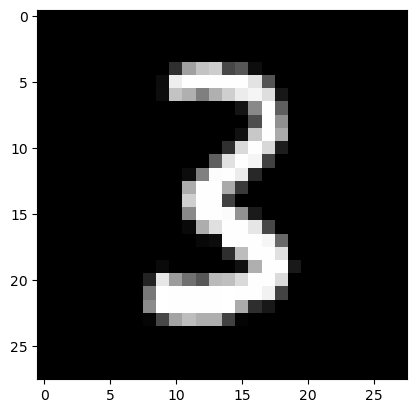

In [74]:
plt.imshow(xb[0].view(28,28))
yb[0]

We've got a DataLoader, we can grab our model and we can simplify 
the `fit` function to just go for `xb,yb` in train_dl. 
And it still works  the same way. 

In [75]:
model,opt = get_model()

In [76]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(loss, preds, yb)

In [77]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.321, 0.938
0.215, 0.938
0.183, 0.938


(tensor(0.05, grad_fn=<NllLossBackward0>), tensor(0.98))

### Random sampling

We want our training set to be in a random order, and that order should differ each iteration. But the validation set shouldn't be randomized.

In [78]:
import random

A feature we should add is that our training set, each time we go through 
it should be in a different, randomized, order. 
Instead of always going through these indexes in order, we want to use random indexes.
We define a class `Sampler`.
If we create a sampler without shuffle, without randomizing it,
it's going to simply return all the numbers from zero up to n in order and it'll be an iterator. 
But if `shuffle=True`, then it will randomly shuffle them. 

In [79]:
class Sampler():
    def __init__(self, ds, shuffle=False): self.n,self.shuffle = len(ds),shuffle
    def __iter__(self):
        res = list(range(self.n))
        if self.shuffle: random.shuffle(res)
        return iter(res)

Here is a sampler without shuffle. 
We make an iterator from that and print a few things, it's just printing out the indexes.

In [80]:
ss = Sampler(train_ds)

In [81]:
it = iter(ss)
for o in range(5): print(next(it))

0
1
2
3
4


Or we can do exactly the same thing using islice. 

In [82]:
from itertools import islice

list(islice(ss, 5))

[0, 1, 2, 3, 4]

We can grab the first five things from a sampler when it's not shuffled, just indexes.  
When we add `shuffle=True`, it's going to call `random.shuffle()`, which just randomly permuts them. 
And now we do the same  thing, we've got random indexes of the source data.  

In [83]:
ss = Sampler(train_ds, shuffle=True)
list(islice(ss, 5))

[26072, 3651, 16294, 16760, 39041]

So why is that useful? 
Lets create a BatchSampler, that is going to do the islice thing for us. 
So we're going to say, pass in a `sampler`, something that generates indices and pass in a batch size `bs`. 
It's going to chunk that iterator by that batch size.

In [84]:
import fastcore.all as fc

class BatchSampler():
    def __init__(self, sampler, bs, drop_last=False):
#         sampler,bs,drop_last = self.sampler,self.bs,self.drop_last
        fc.store_attr()

    def __iter__(self): yield from fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)

Now we can say please take our sampler and create batches of 4.
And it's creating batches of four indices at a time. 
Rather than looping through them in order, I  can now loop through this BatchSampler.

In [85]:
batchs = BatchSampler(ss, 4)
list(islice(batchs, 5))

[[37012, 43244, 40429, 34663],
 [12985, 17703, 9292, 18362],
 [428, 25760, 30547, 25762],
 [42282, 3020, 46111, 28769],
 [3607, 2216, 28326, 19969]]

the `collate` function, which is going to grab a batch, 
pull out the x’s and y’s separately, and then stack them up into tensors.  

In [86]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

Q: What does COLLATE do?  Below explores the steps.
We've got a BatchSampler let's use the valid_ds to create a `t_samp` sampler,
and then go through each thing in it. 

In [87]:
t_samp = BatchSampler(Sampler(train_ds, shuffle=False), bs)

Let's grab one output thing `o` from `test_samp` the batchsampler. 
This contains `bs` 64 indexes in order. 

In [88]:
o = next(iter(t_samp))
len(o), o[:10]

(64, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

If we did a training sampler, `t2_samp` with `shuffle=True` that order would be randomized.

In [89]:
t2_samp = BatchSampler(Sampler(train_ds, shuffle=True), bs)
o2 = next(iter(t2_samp))
len(o2), o2[:10]

(64, [23701, 37829, 41017, 9289, 6048, 46773, 22653, 8740, 44680, 18686])

What did the BatchSampler produced? 

In [90]:
p = o[0]; 
type(o), len(o), type(p), type(o[0])

(list, 64, int, int)

**TODO: Fix explanation of collate to be generic....**
The new Dataloader does
`def __iter__(self): yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)`
Then we do `self.ds[i] for i in b`. 
Let's copy and replace `self.ds[i]` by `valid_ds[i]` and `b` by `o`.  
So lets see what that created, e.g., `p[0]` is a tuple. 
It's got  the `x` and the `y`, independent variable, which is not what we want. 
We want is something that  we can loop through. We want to get batches. 

In [91]:
p = [train_ds[i] for i in o]
type(p)

list

In [92]:
p[0][1], len(p[0][0])

(tensor(5), 784)

The collate function is going to take all the x’s and y’s and collate them into 2 tensors, 
one tensor of x’s and one tensor of y’s.
It does that by calling `zip()`, which allows us to transpose things
so that now we've got all of the second elements (index 1) elements all together and all of the index 0 elements together. 
And  so then we can stack those all up together  and that gives us our y’s for our batch. 

In [93]:
xs,ys = zip(*p)

In [94]:
xs[0][0]

tensor(0.)

In [95]:
torch.stack(ys)

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
        3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0])

So we're going to change our data loader so that now it's going to take some BatchSampler. 
And it's going to loop through the  BatchSampler and give us indices.
And then we're going to get that Dataset item from that batch for everything in that batch.
So that's going to give us a list. 
And then we  have to stack all of the x’s and all of the y’s together into tensors using `collate`. 

In [96]:
#Todo HW Experiment with these to see what everything is taking in
class DataLoader():
    def __init__(self, ds, batchs, collate_fn=collate): fc.store_attr()
    def __iter__(self): yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)

Now we can create a training/validation sampler, `train_samp`/`valid_samp` 
which is a batch sampler over the training/validation set with `shuffle=True/False.`

In [97]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True ), bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

And so then we can pass that  into this DataLoader class, the training data set and the training sampler. 

In [98]:
train_dl = DataLoader(train_ds, batchs=train_samp)
valid_dl = DataLoader(valid_ds, batchs=valid_samp)

We do as before `xb, yb, next, iter`, and this time we use the valid DataLoader, check the shapes. 
This is how PyTorch's DataLoader works, all the pieces they have. 
They have  samplers, batch samplers,  a collation function and  DataLoaders. <br>
Homework is experimenting with these carefully to see  exactly what each thing's taking in.

tensor(3)

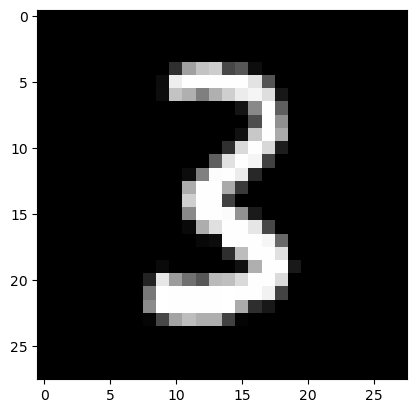

In [99]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [100]:
xb.shape,yb.shape

(torch.Size([64, 784]), torch.Size([64]))

In [101]:
model,opt = get_model()

In [102]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.109, 1.000
0.022, 1.000
0.043, 1.000


(tensor(0.04, grad_fn=<NllLossBackward0>), tensor(1.))

### Multiprocessing DataLoader
The PyTorch DataLoader has a lot more code because it implements multi-processing.
The dataloader could be doing a lot of work for each item in the  batch, 
e.g., opening a JPEG, rotating it, flipping it, etc., so we'd want to do all in parallel.
Python has a multi-processing library, but it doesn't work well with PyTorch tensors.
PyTorch created a re-implementation of it, identical API, but works well with tensors. 
This is not "cheating" because multi-processing is in the Python standard library,
since this is API equivalent, we can use it.  

In [103]:
import torch.multiprocessing as mp
from fastcore.basics import store_attr

When we call square brackets `[]` on a class, it's calling the `__getitem__` function on the object. 
If we say, give me some items (e.g., 3, 6, 8, and 1),  it's the same as calling `__getitem__` passing in 3, 6, 8, and 1.  

In [104]:
train_ds[[3,6,8,1]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [105]:
train_ds.__getitem__([3,6,8,1])

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

`map` is the other key piece of "map-reduce".
`map` takes a sequence and calls a function on every element of that sequence. 
Given a couple of batches of indices, `[3,6]` and `[8,1]`, we call` __getitem__`  on each of those batches. 
So its going to give us the same stuff, but now batched into two batches. 

In [106]:
for o in map(train_ds.__getitem__, ([3,6],[8,1])): print(o)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 1]))
(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 0]))


Multiprocessing has `mp.pool` where tell it how many worker (processes) we want to run.
And it has a `pool.map` which is like the normal Python map, but it runs this function in parallel 
over the items from this iterator.
This is how we can create a multiprocessing  DataLoader. 

In [107]:
class DataLoader():
    def __init__(self, ds, batchs, n_workers=1, collate_fn=collate): fc.store_attr()
    def __iter__(self):
        with mp.Pool(self.n_workers) as ex: yield from ex.map(self.ds.__getitem__, iter(self.batchs))

`train_dl` below is a multiprocessing DataLoader, with `n_workers=2`,
We don't pass in the collate function because we're using the default one.

In [108]:
train_dl = DataLoader(train_ds, batchs=train_samp, n_workers=2)
it = iter(train_dl)

When we say next, it takes a moment to fire off the two workers in the background.
So the first batch comes out more slowly, but once those processes are fired up, it's  going to be faster to run. 

In [109]:
xb,yb = next(it)
xb.shape,yb.shape

(torch.Size([64, 784]), torch.Size([64]))

### PyTorch DataLoader
Instead of a single sampler, Pytorch has two separate classes: `SequentialSampler` and `RandomSampler`,
and they've got BatchSampler.

In [110]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

The training (validation) sampler is a BatchSampler with a RandomSampler (SequentialSampler).

We define the samplers, passing them in batch sizes `bs`. 

In [111]:
train_samp = BatchSampler(RandomSampler(train_ds),     bs, drop_last=False)
valid_samp = BatchSampler(SequentialSampler(valid_ds), bs, drop_last=False)

And so we can now pass  those samplers to the PyTorch’s DataLoader. 
It also takes a collate function, works the same as ours with the same API.

In [112]:
train_dl = DataLoader(train_ds, batch_sampler=train_samp) #, collate_fn=collate)
valid_dl = DataLoader(valid_ds, batch_sampler=valid_samp) #, collate_fn=collate)

In [113]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.217, 0.938
0.161, 1.000
0.011, 1.000


(tensor(0.12, grad_fn=<NllLossBackward0>), tensor(0.95))

Some shortcuts, e.g., we can just pass the batch size directly to a DataLoader, 
and it will auto-create the batchsamplers, so we don't have to pass in BatchSampler. 
Instead we just say `sampler=`, and it will  automatically wrap that in the batchsampler. 

PyTorch can auto-generate the BatchSampler for us:

In [114]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds)) #, collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds)) #, collate_fn=collate)

Because it's common to create  a RandomSampler or a SequentialSampler for a Dataset, 
we can just pass in `shuffle=True` or `shuffle=False` to the DataLoader,
and PyTorch generates the Sequential/RandomSamplers too:

In [115]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True, num_workers=2)
valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=2)

In [116]:
model,opt = get_model()
fit()

loss_func(model(xb), yb), accuracy(model(xb), yb)

0.115, 0.984
0.174, 0.953
0.035, 0.984


(tensor(0.11, grad_fn=<NllLossBackward0>), tensor(0.97))

The batchsampler and the `collation` function are taking the result of the sampler, 
looping through them,  and then collating them together.  
Datasets know how to grab multiple indices at once, so we can just use the BatchSampler as a sampler. 
We don't have to loop through them and collate them because they come pre-collated. 

**TODO**: understand how we can pass a BatchSampler to sampler and what's it doing.
For this, lets go back to our non-multi-processing pure Python code to see how that would work. 
It's a nifty trick to grab multiple things at once and it can save time, make code faster. 

In [117]:
train_ds[[4,6,7]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([9, 1, 3]))

...that means that we can skip the `batch_sampler` and `collate_fn` entirely:

In [118]:
train_dl = DataLoader(train_ds, sampler=train_samp)
valid_dl = DataLoader(valid_ds, sampler=valid_samp)

In [119]:
xb,yb = next(iter(train_dl))
xb.shape,yb.shape

(torch.Size([1, 64, 784]), torch.Size([1, 64]))

## Validation


You **always** should also have a [validation set](http://www.fast.ai/2017/11/13/validation-sets/), in order to identify if you are overfitting.<br>
We will calculate and print the validation loss at the end of each epoch.
<br>
(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

The first part of `fit` is the same code as before.
Then we add a `for xb,yb in valid_dl` which goes through the validation set,
gets the predictions `pred`, sums up the losses and accuracies,
and from time to time prints the loss and accuracy. 

In [120]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tot_loss,tot_acc,count = 0.,0.,0
            for xb,yb in valid_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred,yb).item()*n
                tot_acc  += accuracy (pred,yb).item()*n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count

`get_dls()` will use the PyTorch DataLoader.
The process is `get_dls()` passing in the training and validation dataset.
Notice that for the validation DataLoader, we double the `batch_size`,
as it doesn't have to do backpropagation, it should use about half the memory, so we can use a bigger batch size.

In [121]:
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs)) # double bs because it does not need to do backprop

Now, our whole process of obtaining the data loaders and fitting the model can be run in 3 lines of code:

In [122]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()
loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 0.17526952915340663 0.9497
1 0.14676768591180445 0.9563
2 0.20965474199056625 0.9341
3 0.11569478255957365 0.9662
4 0.18093212896287442 0.9536


And now it's printing out the loss and accuracy on the **validation** set.
So finally we actually know accuracy on the whole validation set.
We've now implemented a working training loop, where every line of code is calling stuff that we have implemented.

In [ ]:
import nbdev; nbdev.nbdev_export()